In [1]:
import sys, pickle
sys.path.append('src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.stats import permutation_test
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from utils import lognormal_gen, generate_matrix
from visualization import *

## Preparations

In [2]:
rng = np.random.default_rng()
IMG_DIR = 'svg/'
RESULT_DIR = 'results/'
AUD_MAP_TYPE, ALT_REC_PLASTICITY, HVC_COND = 'neighbor', 'EIIE', 'mature_hvc'
# AUD_MAP_TYPE in ('neighbor', 'gaussian', 'discrete')
# ALT_REC_PLASTICITY in ('EI', 'EIIE')
# HVC_COND in ('mature_hvc', 'developing_hvc')

### Constants

In [3]:
NE, NI, N_HVC = 600, 150, 15
PEAK_RATE, KERNEL_WIDTH = 150, 20
tauE, tauI, dt = 30, 10, 1

# EI transfer function parameters
rEmax, rImax, thE, thI, slope = 100, 100, 0, 0, 2

### Read and map auditory inputs

In [4]:
fname = 'realistic_auditory_processing/learned_song_responses.npz'
ma = 1/100 if AUD_MAP_TYPE=='discrete' else None
aud_real, mapping = read_realistic_input(fname, NE, mean=0, scale=2, 
                                         mapping=AUD_MAP_TYPE, mapping_args=ma)

### Constants related to time

In [5]:
# Time window of perturbation
PERT_T0 = int(np.round(aud_real['pert_t0'].min(), -1))
PERT_T1 = int(np.round(aud_real['pert_t1'].max(), -1)) + 100

T_post = 200 # Silence after song
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 35 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

### Generate auditory inputs for training

In [6]:
aud, _ = generate_realistic_aud(aud_real['ctrl'], N_rend, T_burn, T_post)

### Generate HVC activities for training

In [7]:
_ = np.arange(N_rend)
# (N_HVC, N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
save_W_ts = np.round(burst_ts[-1]+KERNEL_WIDTH).astype(int)

if HVC_COND == 'mature_hvc':
    _ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
    rH = generate_HVC(T, burst_ts, PEAK_RATE+_*0.1, KERNEL_WIDTH+_*0.01)
    
elif HVC_COND == 'developing_hvc':
    peak_rates = np.zeros_like(burst_ts)
    kernel_widths = np.zeros_like(burst_ts) + KERNEL_WIDTH
    for i in range(N_rend):
        # discount factor j; divided by np.tanh(N_rend/2/15)+1.15 to make sure j(i=0) = 1
        j = (np.tanh(-(i-N_rend/2)/15)+1.15) / (np.tanh(N_rend/2/15)+1.15)
        burst_ts[:,i] += rng.normal(loc=0, scale=100*j, size=N_HVC)
        peak_rates[:,i] = lognormal_gen(rng, PEAK_RATE, 70*j, size=N_HVC)
        kernel_widths[:,i] += rng.exponential(60*j, size=N_HVC)
    rH = generate_HVC(T, burst_ts, peak_rates, kernel_widths)
    
    # Plot HVC over training rends
    js = (0, int(np.floor(N_rend/3)), int(np.floor(N_rend*2/3)), N_rend-1)
    fig, ax = plt.subplots(1, len(js), figsize=(6, 2), sharex='all', sharey='all')
    for i, j in enumerate(js):
        ax[i].plot(rH[T_burn+j*T_rend:T_burn+(j+1)*T_rend-T_post])
        ax[i].set_title('rend%d' % (j+1), fontsize=12)
    ax[0].set(xlabel='time (ms)', ylabel='premotor rates (Hz)')
    fig.savefig(os.path.join(IMG_DIR, 'supplementary/HVC_development.svg'))

### Initialize recurrent weights

In [8]:
gen = lognormal_gen
c = 0.5
# JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.3, 1.8]) / 5
srKEc, srKIc = np.sqrt(NE*c), np.sqrt(NI*c)
JEE0, JEI0, JIE0, JII0 = np.array([1/srKEc, 1.7/srKIc, 1/srKEc, 1.5/srKIc]) / 10
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=True)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=True)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=True)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=True)

## Initialize networks

In [9]:
w0_mean_HVC2E, w0_std_HVC2E, cW_HVC2E = 1/N_HVC, 1e-2, 1

net_FF = WCNet(NE, N_HVC, w0_mean_HVC2E, (rEmax, thE+6, slope), tauE, w0_std=w0_std_HVC2E)
net_HVC2E = EINet(NE, NI, N_HVC, w0_mean_HVC2E, (rEmax, thE+6, slope), (rImax, thI, slope), tauE, tauI, 
                  JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                  w0_std=w0_std_HVC2E, cW=cW_HVC2E)

Not a recurrent model and rI will not be calculated.


In [10]:
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05

net_E2E = EINet(NE, NI, N_HVC, w0_mean_E2E, (rEmax, thE, slope), (rImax, thI, slope), tauE, tauI, 
                JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                w0_std=w0_std_E2E, cW=cW_E2E)
net_E2I = EINet(NE, NI, N_HVC, w0_mean_E2E, (rEmax, thE, slope), (rImax, thI, slope), tauE, tauI, 
                JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                w0_std=w0_std_E2E, cW=cW_E2E)

## Training

### Initial conditions

In [11]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)

### Train FF and EI (premotor->E)

In [12]:
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-3e-2, 
                         tauW=1e5, asyn_H=10, rE_th=1.5)
rE_FF, rI, Ws_FF, _, _ = net_FF.sim(hE0, rH, aud, save_W_ts, T, dt, 0.1, **plasticity_kwargs)

plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-3e-2), 
                         tauW=1e5, asyn_H=10, rE_th=1.5)
rE_HVC2E, rI, Ws_HVC2E, _, _ = net_HVC2E.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                             **plasticity_kwargs)

100%|███████████████████████████████████| 35499/35499 [00:14<00:00, 2446.22it/s]


#### Plot correlations between weights and auditory patterns

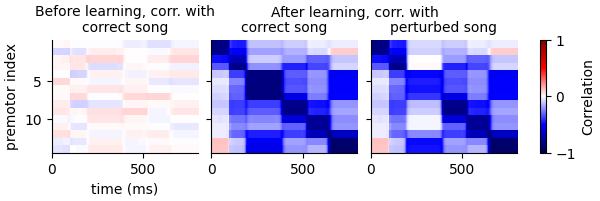

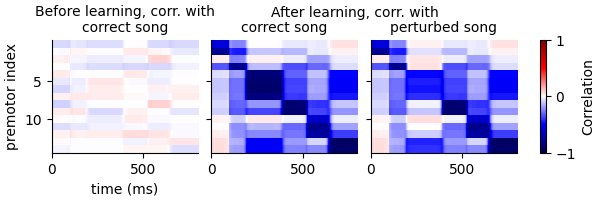

In [13]:
fig, ax = plot_corr_mat(Ws_FF, aud_real['ctrl'].mean(axis=0).T, 
                        aud_real['pert_strong'].mean(axis=0).T,
                        ylabel='premotor index', yticks=[5, 10], xlabel='time (ms)')
fig.savefig(os.path.join(IMG_DIR, 'supplementary/FF_learn_res_%s.svg' % HVC_COND))
fig, ax = plot_corr_mat(Ws_HVC2E['HVC'], aud_real['ctrl'].mean(axis=0).T, 
                        aud_real['pert_strong'].mean(axis=0).T,
                        ylabel='premotor index', yticks=[5, 10], xlabel='time (ms)')
fig.savefig(os.path.join(IMG_DIR, 'supplementary/EI_learn_res_%s.svg' % HVC_COND))

### Train EI (E->E plasticity)

In [14]:
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-5e-2),
                         tauW=1e5, JEE0_mean=JEE0, asyn_E=10, rE_th=1.5)
rE_E2E, rI, Ws_E2E, _, _ = net_E2E.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                       **plasticity_kwargs)

100%|████████████████████████████████████| 35499/35499 [00:48<00:00, 732.87it/s]


### Train EI (E->I->E or I->E plasticity)

In [15]:
if ALT_REC_PLASTICITY == 'EI':
    plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI), lr=dict(JEI=5e-2), tauW=1e5, 
                             JEI0_mean=JEI0, asyn_I=10, rE_th=1.5)
elif ALT_REC_PLASTICITY == 'EIIE':
    plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI,JIE=bilin_hebb_IE), 
                             lr=dict(JEI=5e-2,JIE=6e-3), tauW=1e5, 
                             JEI0_mean=JEI0, JIE0_mean=JIE0, 
                             asyn_E=10, asyn_I=0, rE_th=1.5, rI_th=5)
rE_E2I, rI, Ws_E2I, _, _ = net_E2I.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 0.1, 
                                       **plasticity_kwargs)

100%|███████████████████████████████████| 35499/35499 [00:25<00:00, 1405.32it/s]


#### Plot correlations between weights and auditory patterns

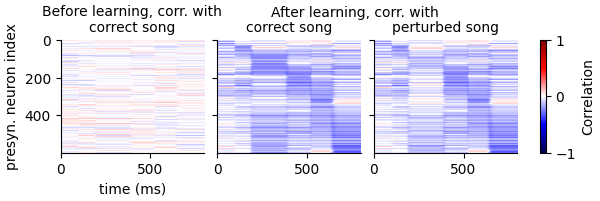

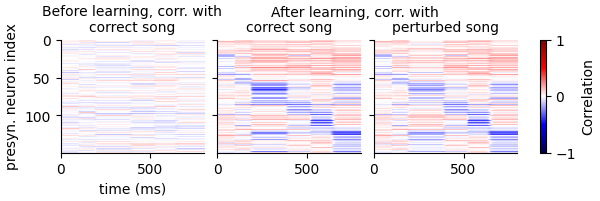

In [16]:
for name, Ws_rec in zip(('EE', ALT_REC_PLASTICITY), (Ws_E2E['JEE'], Ws_E2I['JEI'])):
    if name != 'EE': # one of E->I->E
        Ws_rec = [-w for w in Ws_E2I['JEI']]
    fig, ax = plot_corr_mat(Ws_rec, aud_real['ctrl'].mean(axis=0).T, 
                            aud_real['pert_strong'].mean(axis=0).T, sortby='min', 
                            ylabel='presyn. neuron index', xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'EIrec_learn_res_%s.svg' % (name + HVC_COND)))

#### Plot example neuron and population means during training

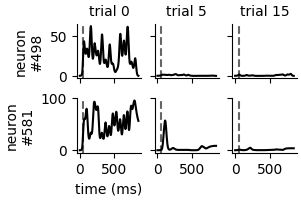

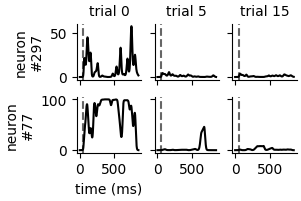

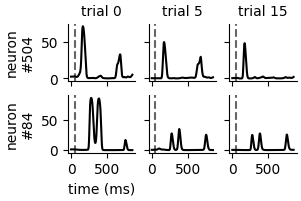

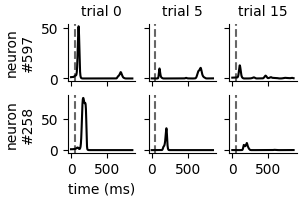

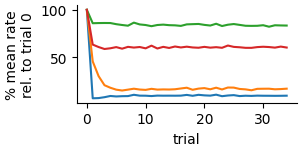

In [20]:
rends = (0, 5, 15)
for name, rE in zip(('FF', 'HVC2E', 'E2E', 'E2I'), (rE_FF, rE_HVC2E, rE_E2E, rE_E2I)):
    avg = [rE[T_burn+j*T_rend:T_burn+(j+1)*T_rend-T_post].mean(axis=0) for j in rends]
    idx = np.where((avg[0]>=avg[1])&(avg[1]>=avg[2]))[0]
    k1 = rng.choice(idx)
    k2 = idx[np.argmax((avg[0][idx] - avg[1][idx]) * (avg[0][idx] - avg[2][idx]))]
    fig, ax = plt.subplots(2, 3, figsize=(3, 2), sharey='row', sharex='all')
    for c, j in enumerate(rends):
        ax[0,c].set_title('trial %d' % j, fontsize=10)
        for i, k in enumerate((k1, k2)):
            ax[i,c].plot(rE[T_burn+j*T_rend-50:T_burn+(j+1)*T_rend-T_post,k], color='k')
            ax[i,c].axvline(50, c='k', alpha=0.6, ls='--')
            ax[i,0].set(ylabel='neuron\n#%d' % k)
    ax[1,0].set(xlabel='time (ms)')
    fig.savefig(os.path.join(IMG_DIR, 'example_neuron_%s.svg' % name))

fig, ax = plt.subplots(1, figsize=(3, 1.5))
for i, rE in enumerate((rE_FF, rE_HVC2E, rE_E2E, rE_E2I)):
    avg = [rE[T_burn+j*T_rend:T_burn+(j+1)*T_rend-T_post].mean() for j in range(N_rend)]
    ax.plot(np.array(avg) / avg[0] * 100, c='C%d' % i)
ax.set(xlabel='trial', ylabel='% mean rate\nrel. to trial 0')
fig.savefig(os.path.join(IMG_DIR, 'mean_rate_evolve.svg'))

## Save results

In [18]:
# # Save models
# with open(os.path.join(RESULT_DIR, 'trained_models_%s_map_%s_%s_%s.pkl') % \
#           (AUD_MAP_TYPE, ALT_REC_PLASTICITY, HVC_COND, TID), 'wb') as f:
#     # need to save the mapping from sparse coding output dim to neuron dim too
#     pickle.dump({'FF': net_FF, 'EI-HVC2E': net_HVC2E, 'EI-E2E': net_E2E, 
#                  'EI-E2I2E': net_E2I, 'mapping': mapping}, f)

# # Save EIrec weights
# with open(os.path.join(RESULT_DIR, 'EIrec_weights_evolve_%s_map_%s_%s_%s.pkl') % \
#           (AUD_MAP_TYPE, ALT_REC_PLASTICITY, HVC_COND, TID), 'wb') as f:
#     pickle.dump({'E2E': Ws_E2E, 'E2I': Ws_E2I}, f)